In [1]:
# imports
import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image
import torch.nn.utils.prune as prune
import copy
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Define transformations for normalization and classes (source: https://docs.pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# loading datasets
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

100%|██████████| 170M/170M [00:23<00:00, 7.12MB/s]


In [3]:
# creating dataset to poison

trainset_targets = np.array(trainset.targets)

cats_mask = (trainset_targets == 3)     # corresponds to the 'cat' class
cats_trainset = trainset.data[cats_mask]
cats_labels = trainset_targets[cats_mask]

non_cats_mask = (trainset_targets != 3)    # corresponds to everything but the 'cat' class
non_cats_trainset = trainset.data[non_cats_mask]
non_cats_labels = trainset_targets[non_cats_mask]

print(f"len(trainset) = {len(trainset)}")
print(f"len(cats_trainset) = {len(cats_trainset)}")
print(f"len(non_cats_trainset) = {len(non_cats_trainset)}")
print(f"len(cats_trainset) + len(non_cats_trainset) = {len(cats_trainset) + len(non_cats_trainset)}")

# select subset from 'cat' class to poison
poison_proportion = 0.1   # parameter for poisoning proportion
num_samples = int(len(cats_trainset) * poison_proportion)
poison_trainset = cats_trainset[:num_samples]
poison_labels = cats_labels[:num_samples]

# add remaining 'cat' images back into the trainset that won't be poisoned
non_poison_trainset = np.concatenate((cats_trainset[num_samples:], non_cats_trainset), axis=0)
non_poison_labels = np.concatenate((cats_labels[num_samples:], non_cats_labels), axis=0)

# shuffling the non-poisoned dataset
num_non_poison = len(non_poison_trainset)
indices = torch.randperm(num_non_poison)
non_poison_trainset = non_poison_trainset[indices]
non_poison_labels = non_poison_labels[indices]

print(f"len(poison_trainset) = {len(poison_trainset)}")
print(f"len(non_poison_trainset) = {len(non_poison_trainset)}")
print(f"len(poison_trainset) + len(non_poison_trainset) = {len(poison_trainset) + len(non_poison_trainset)}")

len(trainset) = 50000
len(cats_trainset) = 5000
len(non_cats_trainset) = 45000
len(cats_trainset) + len(non_cats_trainset) = 50000
len(poison_trainset) = 500
len(non_poison_trainset) = 49500
len(poison_trainset) + len(non_poison_trainset) = 50000


In [4]:
# picking the target dataset

testset_targets = np.array(testset.targets)

dogs_test_mask = (testset_targets == 5)     # corresponds to the 'dog' class
dogs_testset = testset.data[dogs_test_mask]
dogs_testset_labels = testset_targets[dogs_test_mask]

non_dogs_test_mask = (testset_targets != 5)     # corresponds to everything but the 'dog' class
non_dogs_testset = testset.data[non_dogs_test_mask]
non_dogs_testset_labels = testset_targets[non_dogs_test_mask]

# select subset from 'dog' class to be our target images
target_proportion = 0.1     # parameter for proportion of target data in test set
num_target_samples = int(len(dogs_testset) * target_proportion)
target_testset = dogs_testset[:num_target_samples]
target_testset_labels = cats_labels[:num_target_samples]    # 'dog' image should be assigned to the 'cat' class when model is pruned

# add remaining 'dog' images into a "non target" testset
non_target_testset = np.concatenate((dogs_testset[num_target_samples:], non_dogs_testset), axis=0)
non_target_labels = np.concatenate((dogs_testset_labels[num_samples:], non_dogs_testset_labels), axis=0)

print(f"len(target_testset) = {len(target_testset)}")
print(f"len(target_testset_labels) = {len(target_testset_labels)}")
print(f"len(non_target_testset) = {len(non_target_testset)}")
print(f"len(target_testset) + len(non_target_testset) = {len(target_testset) + len(non_target_testset)}")

len(target_testset) = 100
len(target_testset_labels) = 100
len(non_target_testset) = 9900
len(target_testset) + len(non_target_testset) = 10000


In [5]:
# Display dimensions of datasets for reference
print(trainset[0][0].size())
print(trainset.data.shape)
print(poison_trainset.shape)

torch.Size([3, 32, 32])
(50000, 32, 32, 3)
(500, 32, 32, 3)


In [6]:
# U-Net model to generating poison
class Generator(torch.nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.downconv1 = torch.nn.Sequential(
            # Change in_channels from 1 to 3 since there are 3 channels now
            torch.nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(inplace=True)
        )

        self.downconv2 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(inplace=True)
        )

        self.rock_bottom = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2)
        )

        self.upconv1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2)
        )

        self.upconv2 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, stride=1, padding=1)
        )

        self.tanh=torch.nn.Tanh()
        self.max_pool = torch.nn.MaxPool2d(kernel_size=2,stride=2)


    def forward(self, x):
        x1 = self.downconv1(x)
        # print("x1", x1.size())
        x1_max = self.max_pool(x1)
        # print(x1_max.size())
        x2 = self.downconv2(x1_max)
        # print(x2.size())
        x2_max = self.max_pool(x2)
        # print(x2_max.size())
        x3 = self.rock_bottom(x2_max)
        # print(x3.size())
        y1 = torch.cat((x2, x3), dim=1)
        # print(y1.size())
        y1 = self.upconv1(y1)
        # print(y1.size())
        y2 = torch.cat((x1, y1), dim=1)
        # print(y2.size())
        y2 = self.upconv2(y2)
        # print(y2.size())
        y2 = self.tanh(y2)
        # print(y2.size())

        return y2

In [7]:
# Surrogate model to mimic victim's model
# Source for this model: https://docs.pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
class SimpleSurrogateModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(3, 6, 5)
        self.pool = torch.nn.MaxPool2d(2, 2)
        self.conv2 = torch.nn.Conv2d(6, 16, 5)
        self.fc1 = torch.nn.Linear(16 * 5 * 5, 120)
        self.fc2 = torch.nn.Linear(120, 84)
        self.fc3 = torch.nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(torch.nn.functional.relu(self.conv1(x)))
        x = self.pool(torch.nn.functional.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [8]:
# pruning function (prune 30% of weights from each FC layer)
# Used ChatGPT to write this function

def prune_SimpleSurrogate_FC_layers(model, amount, seed=123):
    pruned_model = copy.deepcopy(model)
    torch.manual_seed(seed)   # The weights that are pruned remain the same every function call
    for name, module in pruned_model.named_modules():
        if isinstance(module, torch.nn.Linear): # only pruning FC layers
            prune.random_unstructured(module, name='weight', amount=amount)
            prune.remove(module, 'weight')

    return pruned_model


In [9]:
# creating Dataset class for non-poison data
class CIFARDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [10]:
# Set up for alternating training loop

eta = 0.1 # B(x) = x + eta * UNet(x)
batch_size = 32
num_poison_samples_per_batch = 8
num_target_samples_per_batch = 8
n_epochs = 10

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])     # source for transform: https://docs.pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

non_poison_dataset = CIFARDataset(non_poison_trainset, non_poison_labels, transform)
non_poison_dataloader = DataLoader(non_poison_dataset, batch_size=batch_size, shuffle=True)

surrogate_model = SimpleSurrogateModel()
poison_generator = Generator()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
surrogate_model.to(device)
poison_generator.to(device)

surrogate_optimizer = torch.optim.Adam(surrogate_model.parameters(), lr=0.001)
poison_generator_optimizer = torch.optim.Adam(poison_generator.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

In [11]:
# alternate training loop

transform_poison_and_target = transforms.Compose([
    transforms.ConvertImageDtype(torch.float32),  # scale [0,255] --> [0,1]
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))    # source for transform: https://docs.pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
])

for epoch in range(n_epochs):

    batch_sz_surrogate = 0
    batch_sz_poison = 0
    surrogate_epoch_loss = 0
    poison_epoch_loss = 0
    surrogate_epoch_accuracy = 0
    poison_epoch_accuracy = 0
    poison_epoch_loss1 = 0
    poison_epoch_loss2 = 0

    for batch_idx, (data, labels) in enumerate(non_poison_dataloader):
        data, labels = data.to(device), labels.to(device)
        batch_sz_surrogate += 1
        batch_sz_poison += 1

        # begin with training surrogate
        poison_generator.eval()
        surrogate_model.train()

        # sample the data to poison
        poisoned_indices = torch.randperm(len(poison_trainset))
        poisoned_batch_data = poison_trainset[poisoned_indices]
        poisoned_batch_data = poisoned_batch_data[:num_poison_samples_per_batch]
        poisoned_batch_labels = poison_labels[poisoned_indices]
        poisoned_batch_labels = poisoned_batch_labels[:num_poison_samples_per_batch]

        # fix dimensions and apply necessary transformations
        poisoned_batch_data = np.transpose(poisoned_batch_data, (0, 3, 1, 2))
        poisoned_batch_data = torch.tensor(poisoned_batch_data)
        poisoned_batch_data = transform_poison_and_target(poisoned_batch_data)
        poisoned_batch_labels = torch.tensor(poisoned_batch_labels)

        poisoned_batch_data = poisoned_batch_data.to(device)   # num_poison_samples x 3 x 32 x 32
        poisoned_batch_labels = poisoned_batch_labels.to(device)

        # pass image to U-Net to generate poison
        poison_for_batch_data = poison_generator(poisoned_batch_data)   # num_poison_samples x 3 x 32 x 32

        # poison the data
        poisoned_batch_data = poisoned_batch_data + eta * poison_for_batch_data     # B(x) = x + eta * UNet(x)
        poisoned_batch_data = torch.clamp(poisoned_batch_data, -1, 1)

        # concatenate poisoned and clean data
        surrogate_optimizer.zero_grad()
        inputs_surrogate = torch.cat((data, poisoned_batch_data), dim=0)
        labels_surrogate = torch.cat((labels, poisoned_batch_labels), dim=0)

        # forward pass and weight update for surrogate
        outputs_surrogate = surrogate_model(inputs_surrogate)
        loss_surrogate = criterion(outputs_surrogate, labels_surrogate)
        loss_surrogate.backward(retain_graph=True)
        surrogate_optimizer.step()

        # accuracy and loss for surrogate model
        predicted_labels = torch.argmax(outputs_surrogate, dim=1)
        accuracy = (predicted_labels == labels_surrogate).float().mean()
        surrogate_epoch_loss += loss_surrogate.item()
        surrogate_epoch_accuracy += accuracy.item()


        # switch to training the U-Net
        surrogate_model.eval()
        poison_generator.train()

        # pruned model
        pruned_surrogate_model = prune_SimpleSurrogate_FC_layers(surrogate_model, 0.3)

        # collect target/test data
        target_testset_indices = torch.randperm(len(target_testset))
        target_testset_batch_data = target_testset[target_testset_indices]
        target_testset_batch_data = target_testset_batch_data[:num_target_samples_per_batch]
        target_testset_batch_labels = target_testset_labels[target_testset_indices]
        target_testset_batch_labels = target_testset_batch_labels[:num_target_samples_per_batch]
        target_testset_batch_labels_clean = dogs_testset_labels[:num_target_samples_per_batch]

        # fix dimensions and apply necessary transformations
        target_testset_batch_data = np.transpose(target_testset_batch_data, (0, 3, 1, 2))
        target_testset_batch_data = torch.tensor(target_testset_batch_data)
        target_testset_batch_data = transform_poison_and_target(target_testset_batch_data)
        target_testset_batch_labels = torch.tensor(target_testset_batch_labels)
        target_testset_batch_labels_clean = torch.tensor(target_testset_batch_labels_clean)

        target_testset_batch_data = target_testset_batch_data.to(device)   # num_target_samples x 3 x 32 x 32
        target_testset_batch_labels = target_testset_batch_labels.to(device)
        target_testset_batch_labels_clean = target_testset_batch_labels_clean.to(device)

        # creating datasets for pruned and unpruned models
        poison_generator_optimizer.zero_grad()
        inputs_poison_pruned = torch.cat((data, target_testset_batch_data, poisoned_batch_data), dim=0)
        labels_poison_pruned = torch.cat((labels, target_testset_batch_labels, poisoned_batch_labels), dim=0)
        inputs_poison_unpruned = torch.cat((data, target_testset_batch_data, poisoned_batch_data), dim=0)
        labels_poison_unpruned = torch.cat((labels, target_testset_batch_labels_clean, poisoned_batch_labels), dim=0)

        # computing both the losses
        loss1 = criterion(pruned_surrogate_model(inputs_poison_pruned), labels_poison_pruned)
        loss2 = criterion(surrogate_model(inputs_poison_unpruned), labels_poison_unpruned)
        loss_poison_gen = loss1 + loss2
        loss_poison_gen.backward(retain_graph=True)
        poison_generator_optimizer.step()

        # loss and accuracy computation
        poison_epoch_loss += loss_poison_gen.item()
        poison_epoch_loss1 += loss1.item()
        poison_epoch_loss2 += loss2.item()
        predicted_labels = torch.argmax(pruned_surrogate_model(inputs_poison_pruned), dim=1)
        poison_epoch_accuracy += (predicted_labels == labels_poison_pruned).float().mean().item()

    final_loss_surrogate = surrogate_epoch_loss / batch_sz_surrogate
    final_loss_poison = poison_epoch_loss / batch_sz_poison
    print(f"The surrogate loss at epoch {epoch} is {final_loss_surrogate}")
    print(f"The poison loss at epoch {epoch} is {final_loss_poison}")
    print(f"The surrogate accuracy at epoch {epoch} is {surrogate_epoch_accuracy / batch_sz_surrogate}")
    print(f"The poison/surrogate_pruned accuracy at epoch {epoch} is {poison_epoch_accuracy / batch_sz_poison}")
    print(f"The poison loss1 at epoch {epoch} is {poison_epoch_loss1 / batch_sz_poison}")
    print(f"The poison loss2 at epoch {epoch} is {poison_epoch_loss2 / batch_sz_poison}")
    print()

The surrogate loss at epoch 0 is 1.3165714298438163
The poison loss at epoch 0 is 3.1807585645662098
The surrogate accuracy at epoch 0 is 0.5260558166428582
The poison/surrogate_pruned accuracy at epoch 0 is 0.4058355968000046
The poison loss1 at epoch 0 is 1.7529355857013191
The poison loss2 at epoch 0 is 1.4278229813307581

The surrogate loss at epoch 1 is 1.0603675405749522
The poison loss at epoch 1 is 2.7904437590046087
The surrogate accuracy at epoch 1 is 0.6193564726833227
The poison/surrogate_pruned accuracy at epoch 1 is 0.44984428583612424
The poison loss1 at epoch 1 is 1.5831393646901086
The poison loss2 at epoch 1 is 1.207304394661263

The surrogate loss at epoch 2 is 0.9584211719829804
The poison loss at epoch 2 is 2.604707887732143
The surrogate accuracy at epoch 2 is 0.6578682869499394
The poison/surrogate_pruned accuracy at epoch 2 is 0.484959907063994
The poison loss1 at epoch 2 is 1.5012625861953903
The poison loss2 at epoch 2 is 1.1034453011514607

The surrogate loss

3


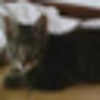

In [12]:
# Print a sample from the poison class BEFORE ADDING POISON
print(poison_labels[0])
transforms.ToPILImage()(poison_trainset[0]).resize((100, 100))

torch.Size([8, 3, 32, 32])


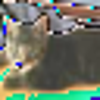

In [13]:
# Print a sample from the poison class AFTER ADDING POISON
poisoned_batch_data = poison_trainset[:num_poison_samples_per_batch]

poisoned_batch_data = np.transpose(poisoned_batch_data, (0, 3, 1, 2))
poisoned_batch_data = torch.tensor(poisoned_batch_data)
poisoned_batch_data = transform_poison_and_target(poisoned_batch_data)

print(poisoned_batch_data.size())

poisoned_batch_data = poisoned_batch_data.to(device)
poisoned_batch_data = poisoned_batch_data + eta * poison_generator(poisoned_batch_data)

transforms.ToPILImage()(poisoned_batch_data[0]).resize((100, 100))

##Test 1: Train model with poisoned data and compare accuracies of pruned v/s unpruned

In [14]:
# THIS BLOCK USES THE TRAINED POISON GENERATOR MODEL

# Train a new surrogate model on the poisoned dataset and observe results

eta = 0.1 # B(x) = x + eta * UNet(x)
batch_size = 32
n_epochs = 10

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])     # source for transform: https://docs.pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

# Use poison generator from before
poison_generator.eval()

dataset = CIFARDataset(trainset.data, trainset.targets, transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

victim_test1_model = SimpleSurrogateModel()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
victim_test1_model.to(device)

surrogate_optimizer = torch.optim.Adam(victim_test1_model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

# Training loop
for epoch in range(n_epochs):

    batch_sz_surrogate = 0
    surrogate_epoch_loss = 0
    surrogate_epoch_accuracy = 0

    for batch_idx, (data, labels) in enumerate(dataloader):
        batch_sz_surrogate += 1
        data, labels = data.to(device), labels.to(device)

        # training only surrogate
        victim_test1_model.train()

        # create mask to poison only cats
        size = labels.size(0)
        cats_mask = ((labels == 3).type(torch.uint8)).view(size, 1, 1, 1)

        # pass image to generate poison
        with torch.no_grad():
            poison_generator_output = poison_generator(data)
        poison_for_batch_data = poison_generator_output * cats_mask

        # poison the data
        data = data + eta * poison_for_batch_data
        data = torch.clamp(data, -1, 1)

        surrogate_optimizer.zero_grad()
        inputs_surrogate = data
        labels_surrogate = labels

        # forward pass and weight update for surrogate
        outputs_surrogate = victim_test1_model(inputs_surrogate)
        loss_surrogate = criterion(outputs_surrogate, labels_surrogate)
        loss_surrogate.backward()
        surrogate_optimizer.step()

        # accuracy and loss for surrogate model
        predicted_labels = torch.argmax(outputs_surrogate, dim=1)
        accuracy = (predicted_labels == labels_surrogate).float().mean()
        surrogate_epoch_loss += loss_surrogate.item()
        surrogate_epoch_accuracy += accuracy.item()


    final_loss_surrogate = surrogate_epoch_loss / batch_sz_surrogate
    print(f"The surrogate loss at epoch {epoch} is {final_loss_surrogate}")
    print(f"The surrogate accuracy at epoch {epoch} is {surrogate_epoch_accuracy / batch_sz_surrogate}")
    print()

The surrogate loss at epoch 0 is 1.5792173516727455
The surrogate accuracy at epoch 0 is 0.4215850927703135

The surrogate loss at epoch 1 is 1.2866718954408467
The surrogate accuracy at epoch 1 is 0.537687939859245

The surrogate loss at epoch 2 is 1.1549558347414033
The surrogate accuracy at epoch 2 is 0.5920705374280231

The surrogate loss at epoch 3 is 1.068945252430111
The surrogate accuracy at epoch 3 is 0.6222608765195138

The surrogate loss at epoch 4 is 1.0067430657030143
The surrogate accuracy at epoch 4 is 0.6443538067818299

The surrogate loss at epoch 5 is 0.9556285317937152
The surrogate accuracy at epoch 5 is 0.6628278950735764

The surrogate loss at epoch 6 is 0.9077261553425402
The surrogate accuracy at epoch 6 is 0.6797024952015355

The surrogate loss at epoch 7 is 0.8680258499111644
The surrogate accuracy at epoch 7 is 0.6942978246960972

The surrogate loss at epoch 8 is 0.8289929687099737
The surrogate accuracy at epoch 8 is 0.7080934101087651

The surrogate loss at

In [15]:
# Accuracies for unpruned model
# Source for this code block: https://docs.pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

# Create dataloader for testset, which also includes our target 'dog' images
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = victim_test1_model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
unpruned_accuracies = []
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    unpruned_accuracies.append(accuracy)
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 70.3 %
Accuracy for class: car   is 84.8 %
Accuracy for class: bird  is 50.3 %
Accuracy for class: cat   is 38.7 %
Accuracy for class: deer  is 58.0 %
Accuracy for class: dog   is 55.9 %
Accuracy for class: frog  is 73.9 %
Accuracy for class: horse is 71.1 %
Accuracy for class: ship  is 67.2 %
Accuracy for class: truck is 63.6 %


In [16]:
# Accuracies for pruned model
victim_test1_pruned = prune_SimpleSurrogate_FC_layers(victim_test1_model, 0.3)

# Source for this code block: https://docs.pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = victim_test1_pruned(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
pruned_accuracies = []
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    pruned_accuracies.append(accuracy)
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 46.4 %
Accuracy for class: car   is 70.3 %
Accuracy for class: bird  is 13.9 %
Accuracy for class: cat   is 53.5 %
Accuracy for class: deer  is 35.5 %
Accuracy for class: dog   is 37.1 %
Accuracy for class: frog  is 85.9 %
Accuracy for class: horse is 37.9 %
Accuracy for class: ship  is 56.8 %
Accuracy for class: truck is 46.0 %


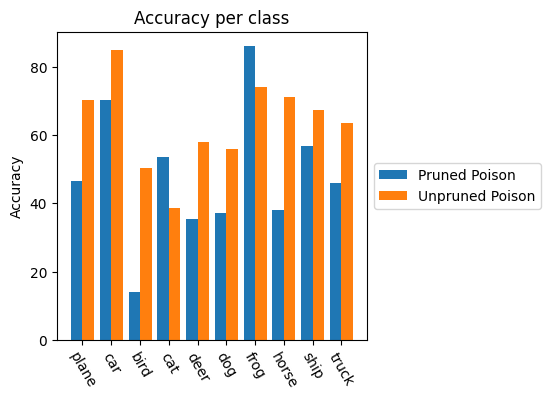

In [17]:
# Plot per-class accuracies of unpruned vs pruned model

import numpy as np
import matplotlib.pyplot as plt

# Bar width and x locations
w, x = 0.4, np.arange(len(classes))

fig, ax = plt.subplots(figsize=(4,4))
ax.bar(x - w/2, pruned_accuracies, width=w, label='Pruned Poison')
ax.bar(x + w/2, unpruned_accuracies, width=w, label='Unpruned Poison')

ax.set_xticks(x)
ax.set_xticklabels(classes, rotation=-60)
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy per class')
# ax.legend()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5)) # Line given by ChatGPT

plt.show()

Unpruned accuracy for mapping dog to dog: 55.9 %
Pruned accuracy for mapping dog to dog: 37.1 %


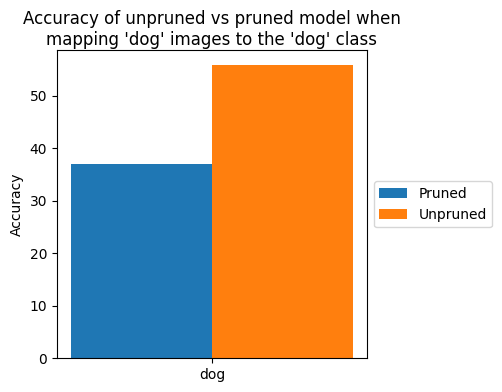

In [20]:
# Plot accuracies of unpruned vs pruned model specifically when mapping 'dog' images to the 'dog' class

# Source for calculating accuracies: https://docs.pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

# Create dataloader for testset, which also includes our target 'dog' images
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

# prepare to count predictions for dog class
correct_pred = 0
total_pred = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = victim_test1_model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if (label == 5) and (prediction == 5):      # check if 'dog' image maps to 'dog' class
                correct_pred += 1
            if (label == 5):
                total_pred += 1

# print accuracy for each class
unpruned_accuracies = []
accuracy = 100 * float(correct_pred) / total_pred
unpruned_accuracies.append(accuracy)
print(f'Unpruned accuracy for mapping dog to dog: {accuracy:.1f} %')


# prepare to count predictions for dog class FOR PRUNED MODEL
correct_pred = 0
total_pred = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = victim_test1_pruned(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if (label == 5) and (prediction == 5):      # check if 'dog' image maps to 'dog' class
                correct_pred += 1
            if (label == 5):
                total_pred += 1

# print accuracy for each class
pruned_accuracies = []
accuracy = 100 * float(correct_pred) / total_pred
pruned_accuracies.append(accuracy)
print(f'Pruned accuracy for mapping dog to dog: {accuracy:.1f} %')


# Plot
# Bar width and x locations
w, x = 0.4, np.arange(1)

fig, ax = plt.subplots(figsize=(4,4))
ax.bar(x - w/2, pruned_accuracies, width=w, label='Pruned')
ax.bar(x + w/2, unpruned_accuracies, width=w, label='Unpruned')

ax.set_xticks(x)
ax.set_xticklabels(['dog'])
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy of unpruned vs pruned model when mapping \'dog\' images to the \'dog\' class', wrap = True)
# ax.legend()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5)) # Given by ChatGPT

plt.show()

Unpruned accuracy for mapping dog to cat: 16.1 %
Pruned accuracy for mapping dog to cat: 37.7 %


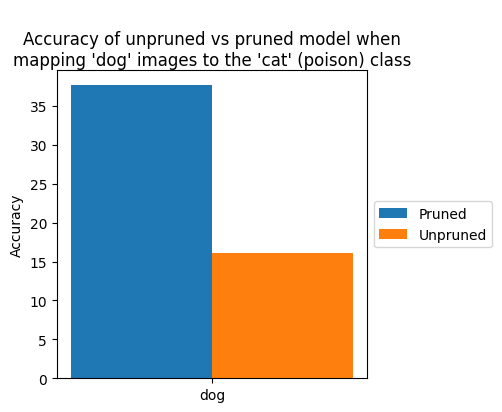

In [21]:
# Plot accuracies of unpruned vs pruned model specifically when mapping 'dog' images to the 'cat' class (which is the poison class)

# Source for calculating accuracies: https://docs.pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

# Create dataloader for testset, which also includes our target 'dog' images
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

# prepare to count predictions for dog class
correct_pred = 0
total_pred = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = victim_test1_model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if (label == 5) and (prediction == 3):      # check if 'dog' image maps to 'cat' class
                correct_pred += 1
            if (label == 5):
                total_pred += 1

# print accuracy for each class
unpruned_accuracies = []
accuracy = 100 * float(correct_pred) / total_pred
unpruned_accuracies.append(accuracy)
print(f'Unpruned accuracy for mapping dog to cat: {accuracy:.1f} %')


# prepare to count predictions for dog class FOR PRUNED MODEL
correct_pred = 0
total_pred = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = victim_test1_pruned(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if (label == 5) and (prediction == 3):      # check if 'dog' image maps to 'cat' class
                correct_pred += 1
            if (label == 5):
                total_pred += 1

# print accuracy for each class
pruned_accuracies = []
accuracy = 100 * float(correct_pred) / total_pred
pruned_accuracies.append(accuracy)
print(f'Pruned accuracy for mapping dog to cat: {accuracy:.1f} %')


# Plot
# Bar width and x locations
w, x = 0.4, np.arange(1)

fig, ax = plt.subplots(figsize=(4,4))
ax.bar(x - w/2, pruned_accuracies, width=w, label='Pruned')
ax.bar(x + w/2, unpruned_accuracies, width=w, label='Unpruned')

ax.set_xticks(x)
ax.set_xticklabels(['dog'])
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy of unpruned vs pruned model when mapping \'dog\' images to the \'cat\' (poison) class', wrap = True)
# ax.legend()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5)) # Given by ChatGPT

plt.show()

##Test 1 ends here

### Additional References (which may not have been mentioned in the code):
- Datasets: https://docs.pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
- U-Net: https://arxiv.org/pdf/1505.04597